In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm

from data.ETL import get_loaders
from data.make_dataset import ImageDataset
from models import UNet, AttentionUNet, TransformerUNet
from utils.Metrics import Metrics
from utils.losses import DiceBCELoss
from utils.plot import plot_losses, plot_generic
from utils.config import DTYPE, get_device
from utils.config import ACCURACY, AUPRC, AUROC_, DICE_SCORE, F1_SCORE, JACCARD_INDEX, PRECISION, RECALL, SPECIFICITY

from solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
device = get_device()
device

device(type='cuda')

In [3]:
# train_dataset = ImageDataset("../data/raw/Br35H-Mask-RCNN/TRAIN", "../data/raw/Br35H-Mask-RCNN/TRAIN_MASK")
# val_dataset = ImageDataset("../data/raw/Br35H-Mask-RCNN/VAL", "../data/raw/Br35H-Mask-RCNN/VAL_MASK")

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

train_ratio = 0.75
val_ratio = 0.15
batch_size = 16

train_loader, val_loader, test_loader = get_loaders("../data/raw/lgg-mri-segmentation/kaggle_3m", train_ratio, val_ratio, batch_size)
print(f'Train samples: {len(train_loader.dataset)}')
print(f'Val samples: {len(val_loader.dataset)}')
print(f'Test samples: {len(test_loader.dataset)}')

Patients: 100%|██████████| 112/112 [00:01<00:00, 71.42it/s]

Train samples: 1029
Val samples: 206
Test samples: 138


In [7]:
best_model = None
best_dice_score = 0.0
best_train_loss_batch_history = None
best_train_loss_history = None
best_val_loss_history = None
best_train_metrics = None
best_val_metrics = None

epochs = 20
channels = (3, 32, 64, 128, 256, 512)
is_residual = False
bias = True
heads = 4
learning_rate = 1e-3
weight_decay = 1e-5
lr_reduce_factor = 0.15
patience = 2

for i in range(1):
    model = UNet(channels, is_residual, bias).to(device)
    criterion = DiceBCELoss(device).to(device=device)
    optimizer = torch.optim.Adam(model.parameters(),)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=lr_reduce_factor, patience=patience)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-6)

    solver = Solver(
        model,
        epochs,
        device,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler
    )

    solver.fit()

    if solver.best_dice_score > best_dice_score:
        best_model = solver.best_model
        best_dice_score = solver.best_dice_score
        best_train_loss_batch_history = solver.train_loss_batch
        best_train_loss_history = solver.train_loss_history
        best_val_loss_history = solver.val_loss_history
        best_train_metrics = solver.train_metrics
        best_val_metrics = solver.val_metrics
        torch.save(best_model, f'saved_models/UNet/UNet_Dice_{best_dice_score}_lr_{learning_rate}_reg_{weight_decay}_channels_{channels[-1]}.pt')


in conv2d
Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
in conv2d
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
in conv2d
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
in conv2d
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
in conv2d
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
in conv2d
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
in conv2d
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
in conv2d
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
in conv2d
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
in conv2d
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
in conv2d
Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
in conv2d
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
in conv2d
Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

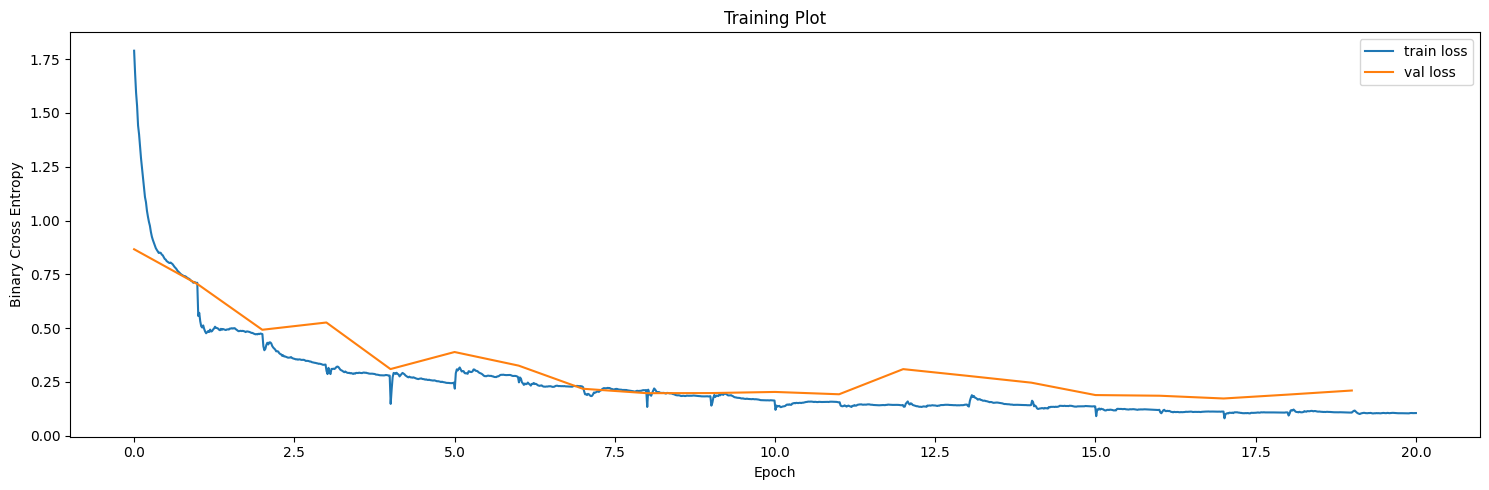

In [19]:
plot_losses(best_train_loss_batch_history, best_val_loss_history)

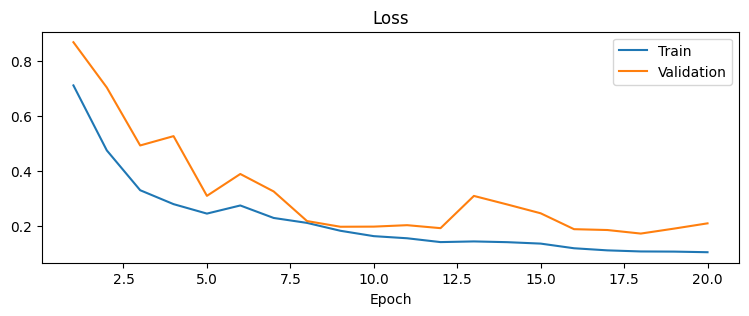

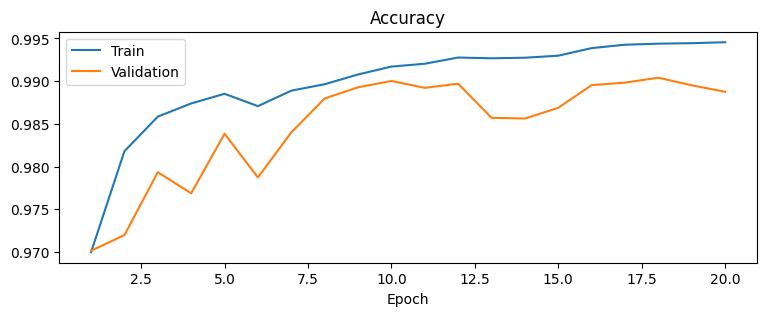

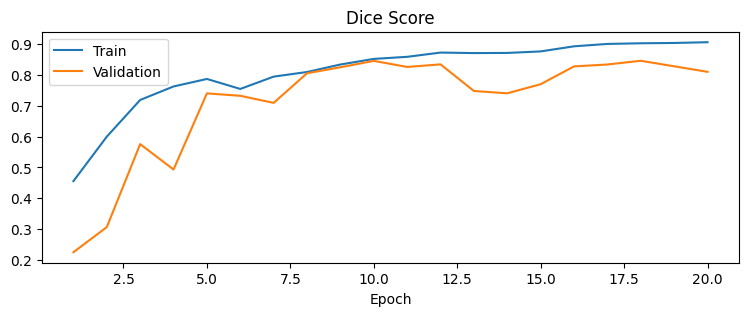

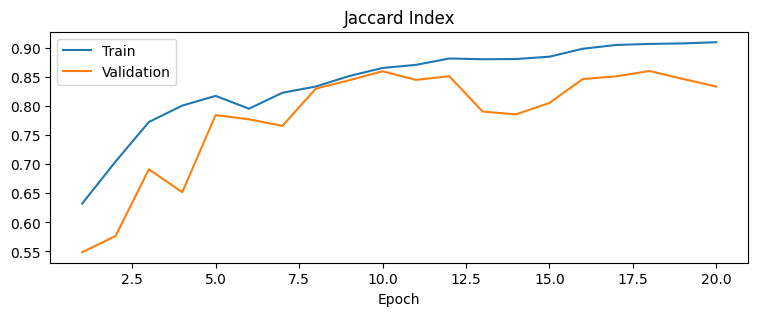

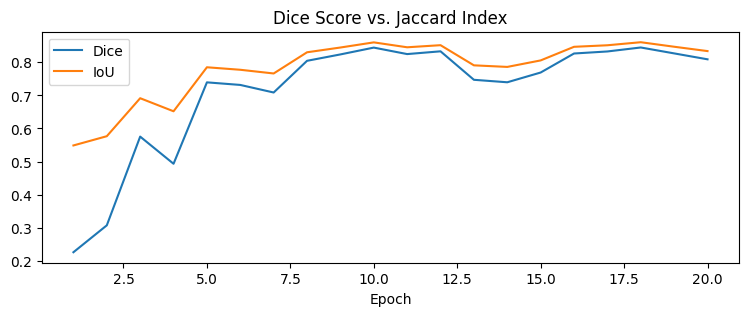

In [20]:
train_metrics_acc = best_train_metrics.get_metrics()
val_metrics_acc = best_val_metrics.get_metrics()
plot_generic('Loss', 'Epoch', 'Train', best_train_loss_history, 'Validation', best_val_loss_history)
plot_generic('Accuracy', 'Epoch', 'Train', train_metrics_acc[ACCURACY], 'Validation', val_metrics_acc[ACCURACY])
plot_generic('Dice Score', 'Epoch', 'Train', train_metrics_acc[DICE_SCORE], 'Validation', val_metrics_acc[DICE_SCORE])
plot_generic('Jaccard Index', 'Epoch', 'Train', train_metrics_acc[JACCARD_INDEX], 'Validation', val_metrics_acc[JACCARD_INDEX])
plot_generic('Dice Score vs. Jaccard Index', 'Epoch', 'Dice', val_metrics_acc[DICE_SCORE], 'IoU', val_metrics_acc[JACCARD_INDEX])